In [4]:
!jupyter labextension install jupyterlab_vim

An error occured.
ValueError: Please install Node.js and npm before continuing installation. You may be able to install Node.js from your package manager, from conda, or directly from the Node.js website (https://nodejs.org).
See the log file for details:  /tmp/jupyterlab-debug-2d6ihali.log


In [5]:
import torch
print(torch.__version__)

1.4.0


In [6]:
!pip install torchsummary

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
from scripts.datasets import CaptionsDataset
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt 
import torchvision
from torchvision import transforms, utils, models 
import numpy as np 
import json 
import custom_models as model 
# from torchsummary import summary
%matplotlib inline

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
def convert_idx_to_word(idx, dic):
    for key, val in dic.items(): 
        if idx == val:
            return key 

In [11]:
MAX_LEGNTH = 16

### Load the Caption Dataset 

In [12]:
SPLIT = 'TRAIN'
DATA_PATH = '/home/ec2-user/SageMaker/efs/200005/processed_flickr30k'
word_dict = '/home/ec2-user/SageMaker/efs/200005/processed_flickr30k/WORDMAP_flickr30k_5_cap_per_img_5_min_word_freq.json'
with open(word_dict, 'r') as f:
    dic = json.load(f)

In [13]:
SOS_token = dic['<start>']
EOS_token = dic['<end>']

In [14]:
SOS_token, EOS_token

(7001, 7002)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The 0 th image...
<start> two young guys with shaggy hair look at their hands while hanging out in the yard <end> 
The 1 th image...
<start> several men in hard hats are operating a giant pulley system <end> <pad> <pad> <pad> <pad> <pad> 
The 2 th image...
<start> a little girl in a pink dress going into a wooden cabin <end> <pad> <pad> <pad> <pad> 
The 3 th image...
<start> a man in a blue shirt is standing on a ladder cleaning a window <end> <pad> <pad> 
The 4 th image...
<start> two guy cooking and joking around with the camera <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The 5 th image...
<start> two people in the photo are playing the guitar and the other is poking at him <end> 
The 6 th image...
<start> a man sits in a chair while holding a large stuffed animal of a lion <end> <pad> 
The 7 th image...
<start> a girl is on rollerskates talking on her cellphone standing in a parking lot <end> <pad> <pad> 
The 8 th image...
<start> three people are standing outside near large pipes and a metal railing <end> <pad> <pad> <pad> <pad> 
The 9 th image...
<start> two men in germany jumping over a rail at the same time without shirts <end> <pad> <pad> 


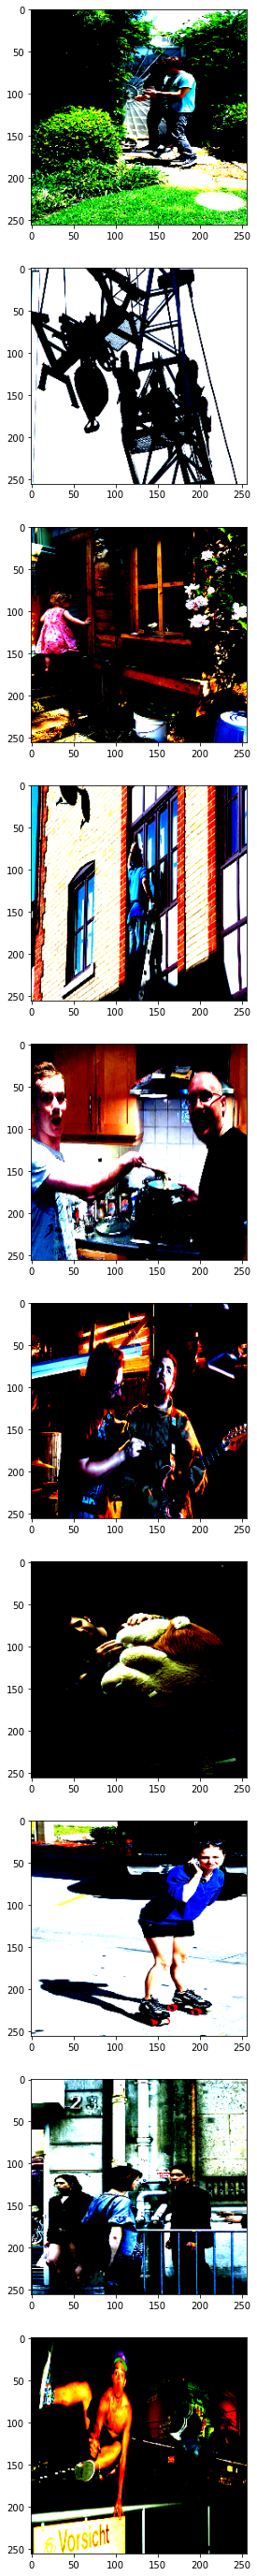

In [15]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

caption_dataset = CaptionsDataset(data_path=DATA_PATH, split=SPLIT, transform=transforms.Compose([transforms.ToTensor(), normalize]))
display_num = 10 
fig = plt.figure(figsize=(50, 50))

for i in range(display_num):
    image, caption, caplen = caption_dataset[i*5]
    for idx in caption:
        print(f"{convert_idx_to_word(idx, dic)}", end=" ")
    print() 
    resized_image = np.transpose(image, (1, 2, 0))
    fig.add_subplot(display_num, 1, i+1)
    plt.imshow(resized_image)
plt.show() 

### DataLoader 

In [16]:
def collate_fn(data):
    """Create mini-batch tensors from the list of tuples (image, caption)

    We should build custom collate_fun rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.

    Args:
       data: list of tuple (image, caption, caplen).
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
            - caplen: length of the caption 

    Returns:
            images: torch tensor of shape (batch_size, 3, 256, 256)
            targets: torch tensor of shape (batch_size, padded_length).
            lengths: list; valid length for each padded caption. 
    """
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions, lengths = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = list(lengths)
    targets = torch.zeros(len(captions), max(lengths)).long() 
    for i, cap in enumerate(captions):
        cap = torch.Tensor(cap)
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths 

The 24 th image...
The 51 th image...
The 1 th image...
The 46 th image...
torch.Size([4, 3, 256, 256]) torch.Size([4, 18]) [18, 15, 13, 12]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[['<start>', 'a', 'man', 'wearing', 'a', 'reflective', 'vest', 'and', 'a', 'hard', 'hat', 'holds', 'a', 'flag', 'in', 'the', 'road', '<end>'], ['<start>', 'an', 'elderly', 'man', 'in', 'a', 'red', 'jacket', 'shielding', 'his', 'face', 'from', 'the', 'sun', '<end>', '<pad>', '<pad>', '<pad>'], ['<start>', 'several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'a', 'giant', 'pulley', 'system', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['<start>', 'a', 'group', 'of', 'people', 'having', 'a', 'barbecue', 'at', 'a', 'park', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']]


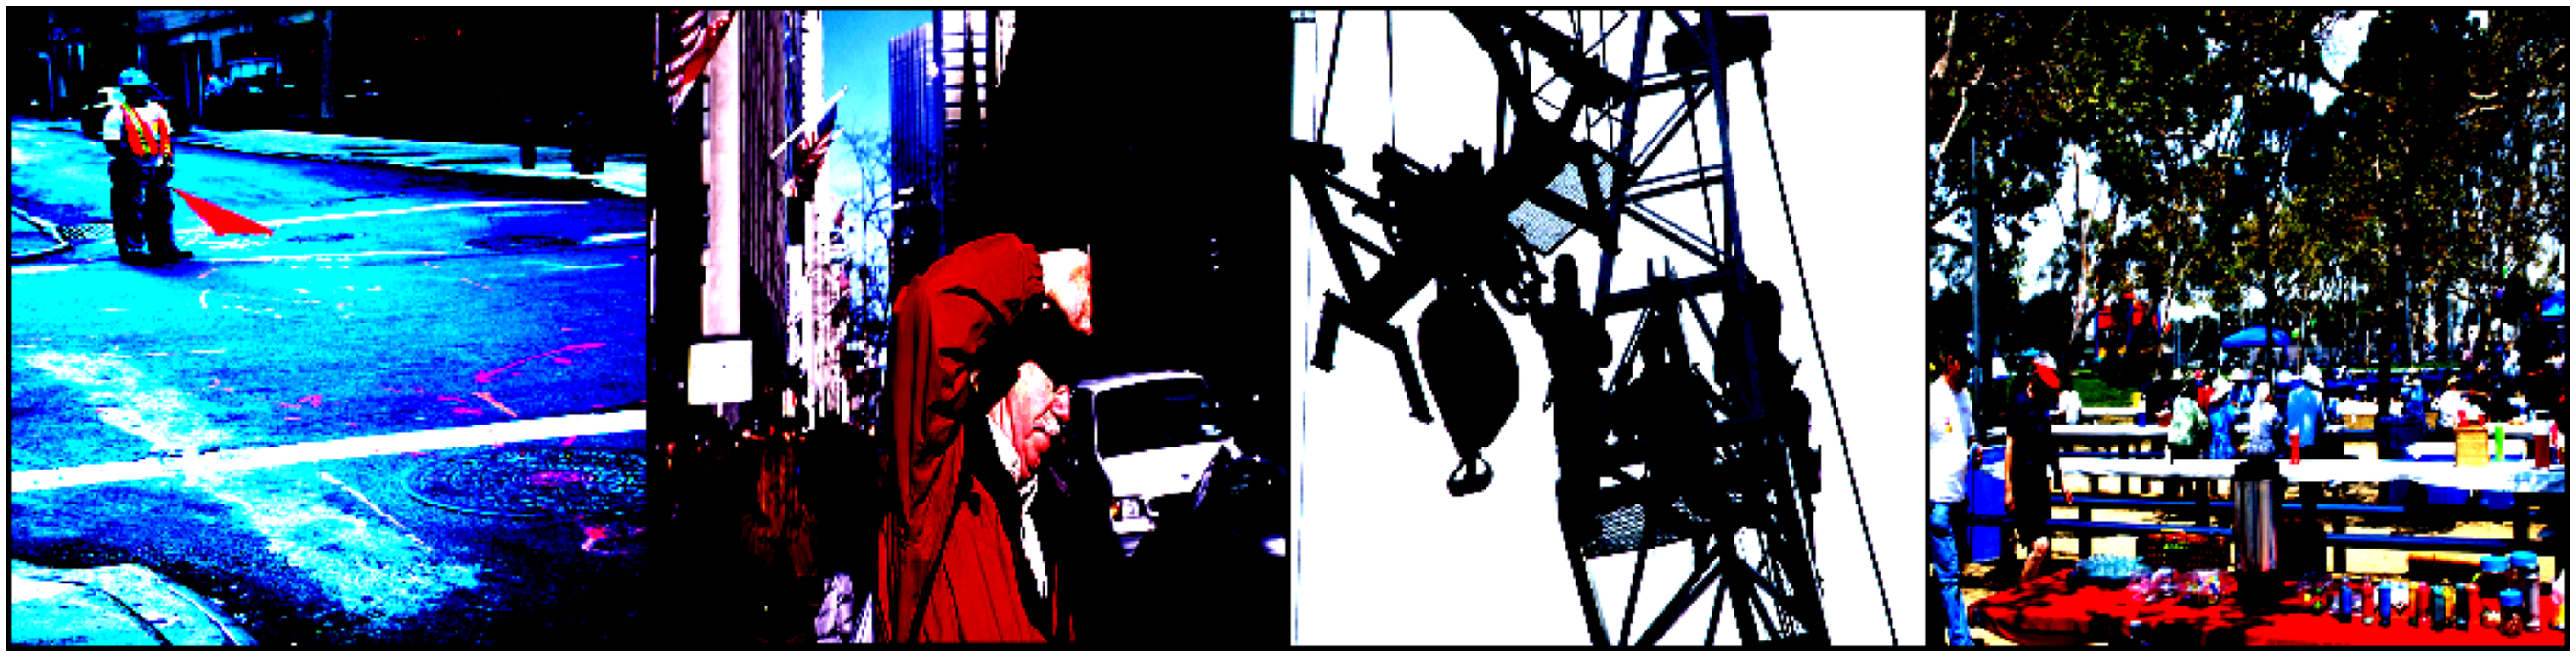

In [17]:
dataloader = DataLoader(caption_dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=collate_fn)

# Helper function to show a batch 
def plot_batch(sample_batched):
    """Show image for a batch of samples."""
    images_batch, captions_batch, lengths = sample_batched[0], sample_batched[1], sample_batched[2]
    print(images_batch.shape, captions_batch.shape, lengths)
    captions = [] 
    for caption_tensor in captions_batch:
        idx_to_word_tensor = list(map(lambda x: convert_idx_to_word(x, dic), caption_tensor))
        captions.append(idx_to_word_tensor)
    print(captions)
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2
    
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose(1, 2, 0))
    
for i_batch, sample_batched in enumerate(dataloader):    
    # observe 0th batch and stop.
    if i_batch == 0:
        plt.figure(figsize=(50, 50)) 
        plot_batch(sample_batched)
        plt.axis('off')
        plt.ioff() 
        plt.show()
        break 

### Training the Model 

In [51]:
max_length = 16 
embedding_dim = 512
hidden_size = 512
output_size = len(dic)
fine_tune_encoder = False 
encoder_lr = 1e-4  # learning rate for encoder if fine-tuning
decoder_lr = 4e-4  # learning rate for decoder

# Loss function
criterion = nn.CrossEntropyLoss().to(device)

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
encoder = model.EncoderCNN(embedding_dim) 

In [20]:
decoder = model.AttnDecoderRNN(hidden_size=hidden_size, output_size=output_size)

In [26]:
encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                             lr=encoder_lr) if fine_tune_encoder else None

In [28]:
decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                             lr=decoder_lr)

In [52]:
teacher_forcing_ratio = 0.5 

#def train(data_loader, encoder, decoder, encoder_optimizer, decode_optimizer, criterion, epoch):
def train():
    """
    performs an epoch of training 
    """
    decoder.train() 
    encoder.train() 
    encoder_hidden = encoder.initHidden() 
    
    # encoder_optimizer.zero_grad() 
    decoder_optimizer.zero_grad() 
    
    encoder_outputs = torch.zeros(max_length, encoder.embedding_dim)
    
    loss = 0 
    
    # each batch 
    for i, (imgs, caps, len_caps) in enumerate(dataloader): 
        
        # send them to GPU 
        imgs = imgs.to(device)
        caps = caps.to(device)
        
        # forward: encode images and decode 
        decoder_hidden = encoder(imgs.float())
        decoder_input = torch.tensor([[SOS_token]], device=device)
        target_length = decoder_hidden.size(0)
        
        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False 

        if use_teacher_forcing:
            # Teacher focing: Feed the target as the next input 
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
                loss += criterion(decoder_output, target_tensor[di])
                decoder_input = target_tensor[di] # Teacher forcing 

In [53]:
train() 

The 64 th image...
The 46 th image...
The 52 th image...
The 63 th image...
> <ipython-input-52-0e763ac75e46>(32)train()
     30         import pdb; pdb.set_trace()
     31 
---> 32         use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
     33 
     34         if use_teacher_forcing:



ipdb>  target_length


4


ipdb>  exit


BdbQuit: 

In [1]:
        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False 

        if use_teacher_forcing:
            # Teacher focing: Feed the target as the next input 
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
                loss += criterion(decoder_output, target_tensor[di])
                decoder_input = target_tensor[di] # Teacher forcing 

        else:
            # Without teacher forcing, use its own predictions as the next input 
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
                topv, topi = decoder_ouput.topk(1)
                decoder_input = topi.squeeze().detach() # detach from history as input 
                loss += criterion(decoder_output, target_tensor[di])
                if decoder_input.item() == EOS_token:
                    break 

        loss.backward() 

        decoder_optimizer.step()
        encoder_optimizer.step() 

        print(loss.item() / target_length)